In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Last date
last_date = session.query(func.max(Measurement.date)).first()
last_date

('2017-08-23')

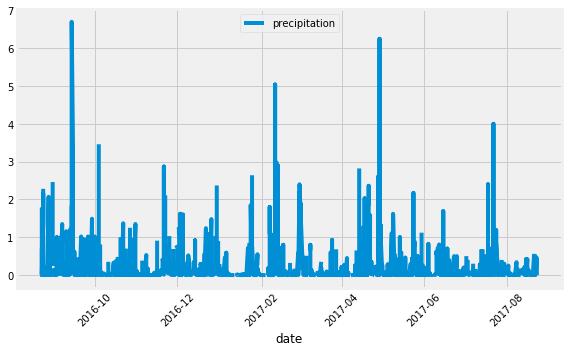

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = dt.date(2017,8,23)

# Calculate the date 1 year ago from the last data point in the database
prev_year = last_date - dt.timedelta(365)


# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= prev_year).\
    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_data, columns=["Date", "Precipitation"])
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")

# Sort the dataframe by date
df = df.sort_values(by="Date")

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(8,5))
plt.plot(df, label='precipitation')
plt.xlabel("date")
plt.xticks(rotation='45')
plt.legend(loc="upper center")
plt.tight_layout()
plt.show()



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summ_stats = df.describe()
summ_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).one()


(9)

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
            
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


# Using most active station/ Id "USC00519281",lowest, highest & Avg Temp
test = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg (Measurement.tobs)).\
    filter(Measurement.station == most_active_stations[0][0]).all()
test
                


[(54.0, 85.0, 71.66378066378067)]

<function matplotlib.pyplot.show(*args, **kw)>

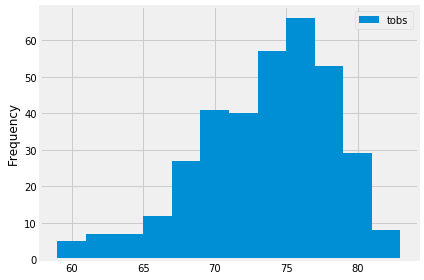

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 

results = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_stations[0][0]).\
    filter(Measurement.date >= '2016-08-23').all()

# Plot the results as a histogram
station_high_temp_obs = pd.DataFrame(results, columns=['tobs'])
station_high_temp_obs.plot.hist(bins=12)
plt.tight_layout()
plt.show




## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

tmin, tavg, tmax = calc_temps('2017-07-03','2017-07-10')[0]




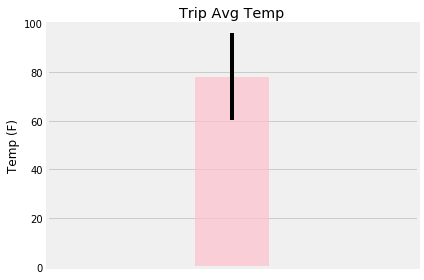

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_pos = 1
yerr= tmax-tmin

plt.bar(x_pos, tavg, yerr=yerr, align='center', width=0.2, bottom=None, color="pink", alpha = 0.7)
plt.xticks(range(x_pos))
plt.ylim(0, 100)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.margins(2.0, 2.0)
plt.tight_layout()
plt.show()




In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date >= '2017-07-15').filter(Measurement.date <= '2017-07-20').\
            group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()
print(rainfall)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.359999999999999), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.52), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.38), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.37), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.33), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.13), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
trip_dates = pd.date_range("2017-07-03", "2017-07-10")


# Stip off the year and save a list of %m-%d strings
date_strings = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in date_strings:
    normals.append(daily_normals(date))
    
print(normals)


[[(68.0, 75.32075471698113, 87.0)], [(70.0, 76.57142857142857, 81.0)], [(66.0, 75.0, 81.0)], [(69.0, 75.0, 81.0)], [(69.0, 74.91071428571429, 82.0)], [(69.0, 76.08333333333333, 83.0)], [(68.0, 76.19298245614036, 83.0)], [(68.0, 75.62068965517241, 82.0)]]


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
index = trip_dates
df = pd.DataFrame(index=index, columns=["tmin", "tavg", "tmax"])
df.index.name = "date"

for x in range(len(normals)):
    df.loc[index[x], "tmin"] = normals[x][0][0]
    df.loc[index[x], "tavg"] = normals[x][0][1]
    df.loc[index[x], "tmax"] = normals[x][0][2]
df

,tmin,tavg,tmax
date,,,
2017-07-03,68,75.3208,87
2017-07-04,70,76.5714,81
2017-07-05,66,75,81
2017-07-06,69,75,81
2017-07-07,69,74.9107,82
2017-07-08,69,76.0833,83
2017-07-09,68,76.193,83
2017-07-10,68,75.6207,82


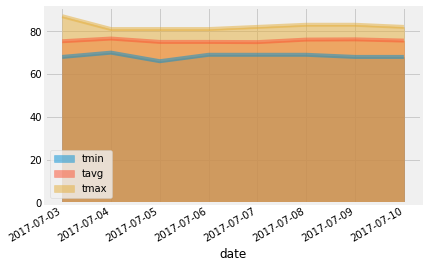

In [24]:
# Plot the daily normals as an area plot with `stacked=False`

df.plot.area(x_compat=True, stacked=False)